In [1]:
import os
import numpy as np
from scipy import io
import fnmatch
import matplotlib.pyplot as plt
from scipy.signal import resample

from auditory_cortex import neural_data_dir, config
from auditory_cortex.neural_data.neural_meta_data import NeuralMetaData
from auditory_cortex.dataloader import DataLoader
from auditory_cortex.models import Regression
%matplotlib inline

metadata = NeuralMetaData()

2024-07-04 14:33:23.543517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 14:33:25.581645: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/gilbreth/cuda-toolkit/cuda-11.2.0/extras/CUPTI/lib64:/apps/gilbreth/cuda-toolkit/cuda-11.2.0/lib64:/apps/spack/gilbreth/apps/intel-mpi/2017.1.132-intel-17.0.1-p7yx74h/compilers_and_libraries_2017.1.132/linux/mpi/intel64/lib:/apps/spack/gilbreth/apps/intel-mpi/2017.1.132-intel-17.0.1-p7yx74h/compilers_and_libraries_2017.1.132/linux/mpi/mic/lib:/apps/spack/gilbreth/apps/intel-parallel-s

In [1]:
from auditory_cortex import cache_dir
cache_dir

'/scratch/gilbreth/ahmedb/cache'

In [2]:
dataloader = DataLoader()
# session = 200206
# dataset = dataloader.get_dataset_object(session)

Using default normalizer file...


In [3]:
model_name = 'whisper_tiny'
bin_width = 50
feats = dataloader.get_resampled_DNN_features(
	model_name, bin_width, 
)

Reading raw features from /scratch/gilbreth/ahmedb/cache/whisper_tiny/whisper_tiny_raw_features.pkl
Resamping ANN features at bin-width: 50


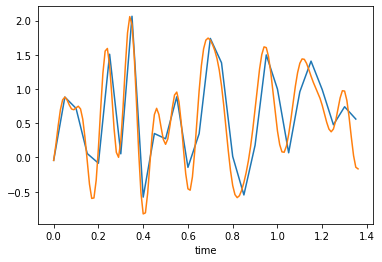

In [24]:
layer = 2
sent = 12
dur = dataloader.metadata.stim_duration(sent)
times_50 = np.arange(0, dur, bin_width/1000)
plt.plot(times_50, feats[layer][sent][:,0])
plt.xlabel("time")

feats_LPF = dataloader.get_resampled_DNN_features(
	model_name, bin_width, LPF=True
)
bin_width_LPF = 10
times_10 = np.arange(0, dur, bin_width_LPF/1000)
plt.plot(times_10, feats_LPF[layer][sent][:,0])

Reading raw features from /scratch/gilbreth/ahmedb/cache/whisper_tiny/whisper_tiny_raw_features.pkl
Resamping ANN features at bin-width: 50


In [20]:

feats_LPF[layer][sent].shape

(137, 384)

In [12]:
dur

1.369625

(28,)

In [6]:
aud = dataloader.get_stim_aud(12)

In [8]:
import naplib as nl
sampling_rate = 16000
spect = nl.features.auditory_spectrogram(aud, sampling_rate, frame_len=10)

In [14]:
print(spect.shape)
type(spect)

(137, 128)


numpy.ndarray

In [11]:
from transformers import Speech2TextForConditionalGeneration, Speech2TextProcessor
processor = Speech2TextProcessor.from_pretrained("facebook/s2t-large-librispeech-asr")

In [24]:
spect = processor(aud, padding=True, sampling_rate=sampling_rate).input_features[0]

In [25]:
print(spect.shape)
type(spect)

(135, 80)


numpy.ndarray

In [4]:
model_name = 'whisper_tiny'
reg_obj = Regression(model_name)

Creating regression obj for: 'whisper_tiny'
Using default normalizer file...


In [5]:
bin_width = 50
session = 200206
mVocs=True
delay=0
features, spikes_all_trials = reg_obj.get_test_data(session, bin_width=bin_width, delay=delay, mVocs=mVocs)
print(f"For mVocs={mVocs}")
print(f"features={features.shape}")
print(f"spikes={spikes_all_trials.shape}")

DataLoader: Extracting spikes for session-200206...
NeuralData:  Creating object for session: 200206 ... Done.
NeuralData: Reading mVocs spikes for 200206. 
Model on device: cuda
Loaded network from openai/whisper-tiny
Reading raw features from /scratch/gilbreth/ahmedb/cache/mVocs/whisper_tiny/whisper_tiny_raw_features.pkl
Resamping ANN features at bin-width: 50
For mVocs=True
features=(6, 231, 384)
spikes=(15, 231, 64)


DataLoader: Extracting spikes for session-200206...
NeuralData: Reading mVocs spikes for 200206. 
For mVocs=True
features=(6, 220, 384)
spikes=(15, 220, 64)


In [8]:
print(f"At delay={delay}")
spikes_all_trials[0, :30, 32]

At delay=0


array([10.,  3.,  2.,  1.,  0.,  8.,  8.,  8.,  4.,  1.,  0.,  0.,  0.,
        0.,  0.,  2.,  1.,  1.,  2.,  1.,  0.,  6.,  5.,  8.,  5.,  3.,
        6.,  1.,  2.,  4.], dtype=float32)

In [ ]:
bin_width = 50
session = 200206
mVocs=True
delay=50
features, spikes_all_trials = reg_obj.get_test_data(session, bin_width=bin_width, delay=delay, mVocs=mVocs)
print(f"For mVocs={mVocs}")
print(f"features={features.shape}")
print(f"spikes={spikes_all_trials.shape}")

In [10]:
print(f"At delay={delay}")
spikes_all_trials[0, :30, 32]

At delay=50


array([3., 2., 1., 0., 8., 8., 8., 4., 1., 0., 0., 0., 0., 0., 2., 1., 2.,
       1., 0., 6., 5., 8., 5., 3., 6., 1., 2., 4., 4., 0.], dtype=float32)

In [14]:
delay = 0
spk = reg_obj.unroll_spikes(session, [6], bin_width=bin_width, delay=delay, mVocs=mVocs)
spk[:,32]


array([10.,  3.,  2.,  1.,  0.,  8.,  8.,  8.,  4.,  1.,  0.,  0.,  0.,
        0.,  0.,  2.], dtype=float32)

In [4]:
tr =0
ch=32
spikes_all_trials[tr, :30, ch]

array([10.,  3.,  2.,  1.,  0.,  8.,  8.,  8.,  4.,  1.,  0.,  0.,  0.,
        0.,  0.,  2.,  1.,  1.,  2.,  1.,  0.,  6.,  5.,  8.,  5.,  3.,
        6.,  1.,  2.,  4.], dtype=float32)

In [6]:
bin_width = 50
session = 200206
mVocs=False
features, spikes_all_trials = reg_obj.get_test_data(session, bin_width=bin_width, mVocs=mVocs)
print(f"For mVocs={mVocs}")
print(f"features={features.shape}")
print(f"spikes={spikes_all_trials.shape}")

For mVocs=False
features=(6, 336, 384)
spikes=(11, 336, 64)


In [7]:
tr =0
ch=32
spikes_all_trials[tr, :30, ch]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [9]:
layer = 2
d = 100
features[layer, :30, d]

array([-0.6285536 , -0.1323043 , -0.4711732 ,  0.46596366, -0.2097826 ,
        1.0800993 ,  0.5084334 , -0.1993565 , -0.2507597 , -0.15545288,
       -0.4503545 ,  0.28529593, -0.62709594,  0.91605043, -0.24149683,
        0.7697495 , -0.31158608, -0.4267629 , -0.21001564,  0.59463936,
        0.45235762,  0.28091955,  1.2953553 ,  0.2949523 , -0.00683712,
        0.29678893,  0.20762457,  0.34504732, -0.37115607,  0.17280062],
      dtype=float32)

In [7]:
bin_width = 50
session = 200206
mVocs=True
features, spikes_all_trials = reg_obj.get_test_data(session, bin_width=bin_width, mVocs=mVocs)
print(f"For mVocs={mVocs}")
print(f"features={features.shape}")
print(f"spikes={spikes_all_trials.shape}")

For mVocs=True
features=(6, 231, 384)
spikes=(15, 231, 64)


In [8]:
tr =0
ch=32
spikes_all_trials[tr, :30, ch]

array([10.,  3.,  2.,  1.,  0.,  8.,  8.,  8.,  4.,  1.,  0.,  0.,  0.,
        0.,  0.,  2.,  1.,  1.,  2.,  1.,  0.,  6.,  5.,  8.,  5.,  3.,
        6.,  1.,  2.,  4.], dtype=float32)

In [9]:
bin_width = 50
session = 200206
mVocs=False
features, spikes_all_trials = reg_obj.get_test_data(session, bin_width=bin_width, mVocs=mVocs)
print(f"For mVocs={mVocs}")
print(f"features={features.shape}")
print(f"spikes={spikes_all_trials.shape}")

For mVocs=False
features=(6, 336, 384)
spikes=(11, 336, 64)


In [12]:
tr =0
ch=32
spikes_all_trials[tr, :30, ch]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [5]:
bin_width = 50
session = 200206
mVocs=True
stim_ids = [2,3,4]
spikes = reg_obj.unroll_spikes(session, stim_ids, bin_width=bin_width, mVocs=mVocs)
print(f"Spikes for mVocs={mVocs}, spikes={spikes.shape}")

Spikes for mVocs=True, spikes=(91, 64)


In [5]:
mVocs=False
bin_width = 50
stim_ids = [2,3,4]
features = reg_obj.unroll_features(
            stim_ids, bin_width=bin_width, mVocs=mVocs
            )
print(f"Features for mVocs={mVocs}, features={features.shape}")

Features for mVocs=False, features=(6, 149, 384)


In [6]:
mVocs=True
bin_width = 50
stim_ids = [2,3,4]
features = reg_obj.unroll_features(
            stim_ids, bin_width=bin_width, mVocs=mVocs
            )
print(f"Features for mVocs={mVocs}, features={features.shape}")

Features for mVocs=True, features=(6, 91, 384)


In [ ]:
bin_width = 50
session = 200206
mVocs=True
stim_ids = [2,3,4]
spikes = reg_obj.unroll_spikes(session, stim_ids, bin_width=bin_width, mVocs=mVocs)
print(f"Spikes for mVocs={mVocs}, spikes={spikes.shape}")

In [3]:
bin_width = 50
session = 200206
features, all_trials = reg_obj.get_test_data(session, bin_width=bin_width, mVoc=True)

DataLoader: Extracting spikes for session-200206...
NeuralData:  Creating object for session: 200206 ... Done.
NeuralData: Reading mVoc spikes for 200206. 


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0


Model on device: cuda


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/generation_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HE

Loaded network from openai/whisper-tiny
Reading raw features from /scratch/gilbreth/ahmedb/cache/mVocs/whisper_tiny/whisper_tiny_raw_features.pkl
Resamping ANN features at bin-width: 50


In [4]:
print(f"For mVocs: features: {features.shape}")
print(f"For mVocs: test_spikes: {all_trials.shape}")

For mVocs: features: (6, 231, 384)
For mVocs: test_spikes: (15, 231, 64)


In [5]:
bin_width = 50
session = 200206
timit_features, timit_all_trials = reg_obj.get_test_data(session, bin_width=bin_width, mVoc=False)

In [7]:
print(f"For timit: features: {timit_features.shape}")
print(f"For timit: test_spikes: {timit_all_trials.shape}")

For timit: features: (6, 217, 384)
For timit: test_spikes: (11, 336, 64)


In [9]:
spikes_all_trials = reg_obj.get_test_sent_spikes(session, bin_width=bin_width)
print(f"For timit: test_spikes: {spikes_all_trials.shape}")

For timit: test_spikes: (11, 336, 64)


In [6]:
dataloader = DataLoader()

sessions = dataloader.metadata.get_all_available_sessions()

bin_width = 50
mVoc = True
excluded_sessions = ['190726', '200213']
for session in sessions:
	if session in excluded_sessions:
		print(f"Excluding session: {session}")
		continue
	features, all_trials = reg_obj.get_test_data(session, bin_width=bin_width, mVoc=True)

	print(f"For sess-{session}, features: {features.shape}, all_trials: {all_trials.shape}")

Using default normalizer file...
DataLoader: Extracting spikes for session-180413...
NeuralData:  Creating object for session: 180413 ... Done.
NeuralData: Reading mVoc spikes for 180413. 
For sess-180413, features: (6, 231, 384), all_trials: (15, 231, 16)
DataLoader: Extracting spikes for session-180420...
NeuralData:  Creating object for session: 180420 ... Done.
NeuralData: Reading mVoc spikes for 180420. 
For sess-180420, features: (6, 231, 384), all_trials: (15, 231, 16)
DataLoader: Extracting spikes for session-180501...
NeuralData:  Creating object for session: 180501 ... Done.
NeuralData: Reading mVoc spikes for 180501. 
For sess-180501, features: (6, 231, 384), all_trials: (15, 231, 16)
DataLoader: Extracting spikes for session-180502...
NeuralData:  Creating object for session: 180502 ... Done.
NeuralData: Reading mVoc spikes for 180502. 
For sess-180502, features: (6, 231, 384), all_trials: (15, 231, 16)
DataLoader: Extracting spikes for session-180613...
NeuralData:  Creati

Creating regression obj for: 'whisper_tiny'
Using default normalizer file...


In [3]:
features, all_spikes = reg_obj.get_test_data(session = 200206, bin_width = 50, delay = 20, numpy=False, mVoc=False)

NeuralData:  Creating object for session: 200206 ... Done.
Model on device: cuda
Loaded network from openai/whisper-tiny
Reading raw features from /scratch/gilbreth/ahmedb/cache/whisper_tiny/whisper_tiny_raw_features.pkl
Resamping ANN features at bin-width: 50


In [4]:
features.shape

(6, 326, 384)

In [5]:
all_spikes.shape

(11, 326, 64)

In [3]:
session = 200206
bin_width = 50
delay = 50
numpy=False 
mVoc=True
stim_ids = [0, 1, 2, 3, 4, 5]
spikes = reg_obj.unroll_spikes(session, stim_ids, bin_width, delay, mVoc=mVoc)
spikes.shape

DataLoader: Extracting spikes for session-200206...
NeuralData:  Creating object for session: 200206 ... Done.
NeuralData: Reading mVoc spikes for 200206. 


(187, 64)

In [4]:
features = reg_obj.unroll_features(stim_ids, bin_width=bin_width, delay=delay, mVoc=mVoc)
features.shape

Model on device: cuda
Loaded network from openai/whisper-tiny
Reading raw features from /scratch/gilbreth/ahmedb/cache/mVocs/whisper_tiny/whisper_tiny_raw_features.pkl
Resamping ANN features at bin-width: 50


(6, 186, 384)

In [16]:
all_layer_features[0].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [9]:
all_spikes = reg_obj.get_test_mVoc_spikes(
	session = 200206, bin_width = 50, delay = 50, numpy=False)

DataLoader: Extracting spikes for session-200206...
NeuralData: Reading mVoc spikes for 200206. 


In [10]:
all_spikes.shape

(15, 220, 64)

In [5]:
all_spikes.shape

(15, 231, 64)

In [8]:
reg_obj.dataloader.metadata.mVoc_test_stimIds

[7, 9, 12, 15, 24, 29, 30, 33, 44, 45, 48]

In [15]:
reg_obj.dataloader.metadata.mVocId_to_trialId[7]

array([  6,  75, 111, 182, 225, 296, 352, 364, 450, 496, 524, 610, 642,
       686, 754])

In [10]:
reg_obj.dataloader.metadata.get_mVoc_sampling_rate()

16000

In [13]:
mVoc_spikes = {}
mVoc_ids = reg_obj.dataloader.metadata.mVoc_test_stimIds
for mVoc in mVoc_ids:
	tr_ids = reg_obj.dataloader.metadata.get_mVoc_tr_id(mVoc)
	all_trial_spikes = []
	for tr in tr_ids:
		all_trial_spikes.append(reg_obj.unroll_spikes(
			session, [tr], bin_width=bin_width, delay=delay, 
			numpy=numpy, mVoc=True
		))
	mVoc_spikes[mVoc] = np.stack(all_trial_spikes, axis=0)
repeated_trials = np.concatenate([mVoc_spikes[mVoc] for mVoc in mVoc_ids], axis=1).astype(np.float32)


In [14]:
repeated_trials.shape

(15, 231, 64)

In [5]:
mVoc_ids

[7, 9, 12, 15, 24, 29, 30, 33, 44, 45, 48]

In [6]:
mVoc = 7

In [12]:
all_trial_spikes.shape

(15, 16, 64)

In [10]:
for i in range(len(all_trial_spikes)):
	print(all_trial_spikes[i].shape)

(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)


In [69]:
tr = 19
win = 50
delay = 20
duration = metadata.get_mVoc_dur(tr)
s_times = np.random.uniform(0, duration, 10)
s_times.sort()
s_times = {0: s_times}

win = win/1000
delay=delay/1000
counts = {}
n = int(np.ceil(duration/win))
# in order to get duration equal to integer multiple of win
# using n+1 because stop entry is not included..
bins = np.arange(delay, delay + (n+1)*win, win)
for ch, times in s_times.items():
	counts[ch], _ = np.histogram(times, bins)

print(f"n= {n}, samples in bins= {counts[0].size}")

n= 14, samples in bins= 14


In [70]:
bins*1000

array([ 20.,  70., 120., 170., 220., 270., 320., 370., 420., 470., 520.,
       570., 620., 670., 720.])

In [152]:


def detect_silence(waveform, threshold, consecutive_samples=1600):
	"""Detects the start of silence and returns the index of first sample"""
	# Find the index where the silence starts
	below_threshold = np.abs(waveform) < threshold
	silence_start = np.argmax(np.convolve(below_threshold, np.ones(consecutive_samples, dtype=int), 'valid') == consecutive_samples)
	return silence_start

def plot_trial_aud(trial_id, ax=None):
	if ax is None:
		fig, ax=plt.subplots()
	# aud = metadata.get_mVoc_aud(trial_id)/30000
	aud = processed_mVoc_wavforms[trial_id]
	ax.plot(aud)
	xticks = np.arange(0, aud.size, 8000)
	ax.set_xticks(xticks, xticks/16000)
	ax.set_xlabel(f"seconds")
	silence_start = detect_silence(aud, 1e-3, 1600)
	if silence_start!= 0:
		ax.axvline(silence_start, color='red')



In [157]:
i = 10
mVoc_id = test_stim_ids[i]
trial_ids = metadata.mVocId_to_trialId[mVoc_id]

for tr in trial_ids:
	# print(new_durations[tr])
	print(round(new_durations[tr], 4))

0.6358
0.6358
0.6358
0.6358
0.6358
0.6358
0.6358
0.6358
0.6358
0.6358
0.6358
0.6358
0.6358
0.6358
0.6358


Text(0.5, 0.98, 'Trial presentations for mVoc ID: 48')

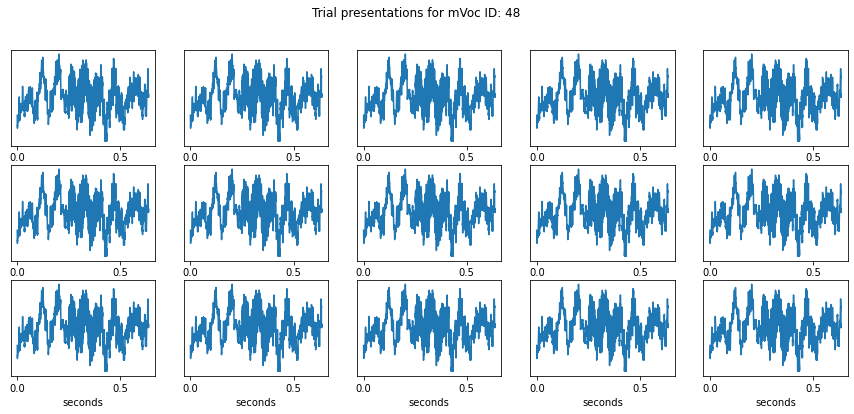

In [158]:
i = 10
mVoc_id = test_stim_ids[i]
trial_ids = metadata.mVocId_to_trialId[mVoc_id]
ncols = 5
num = trial_ids.size
nrows = int(np.ceil(num/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,6))

for i, tr in enumerate(trial_ids):
	ax = axes[i//ncols, i%ncols]
	plot_trial_aud(tr, ax)
	ax.set_yticks([])
plt.suptitle(f"Trial presentations for mVoc ID: {mVoc_id}")

In [4]:
trial_id = 6

def detect_silence(waveform, threshold, consecutive_samples=1600):
	"""Detects the start of silence and returns the index of first sample"""
	# Find the index where the silence starts
	below_threshold = np.abs(waveform) < threshold
	silence_start = np.argmax(np.convolve(below_threshold, np.ones(consecutive_samples, dtype=int), 'valid') == consecutive_samples)
	return silence_start

def plot_trial_aud(trial_id, ax=None):
	if ax is None:
		fig, ax=plt.subplots()
	aud = metadata.get_mVoc_aud(trial_id)
	ax.plot(aud)
	xticks = np.arange(0, aud.size, 8000)
	ax.set_xticks(xticks, xticks/16000)
	ax.set_xlabel(f"seconds")
	silence_start = detect_silence(aud, 1e-3, 1600)
	if silence_start != 0:
		ax.axvline(silence_start, color='red')

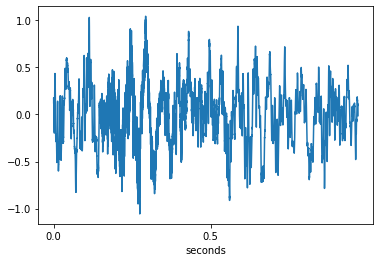

In [5]:
tr=15
plot_trial_aud(tr)

Text(0.5, 0.98, 'Trial presentations for mVoc ID: 48')

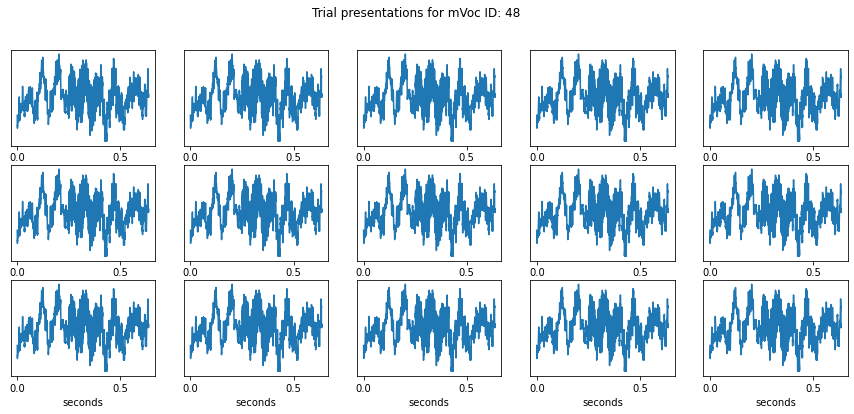

In [8]:
i = 10
test_stim_ids = metadata.mVoc_test_stimIds
mVoc_id = test_stim_ids[i]
trial_ids = metadata.mVocId_to_trialId[mVoc_id]
ncols = 5
num = trial_ids.size
nrows = int(np.ceil(num/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,6))

for i, tr in enumerate(trial_ids):
	ax = axes[i//ncols, i%ncols]
	plot_trial_aud(tr, ax)
	ax.set_yticks([])
plt.suptitle(f"Trial presentations for mVoc ID: {mVoc_id}")

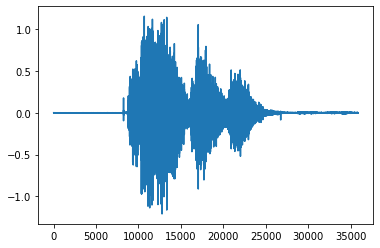

In [85]:
tr=12
aud = metadata.get_mVoc_aud(tr)
plt.plot(aud)

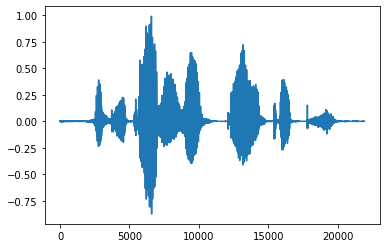

In [13]:
aud = metadata.stim_audio(12)
plt.plot(aud)

In [2]:
dataloader = DataLoader()

Using default normalizer file...


In [3]:
model_name = 'whisper_tiny'
bin_width = 50
mVoc=True
features = dataloader.get_resampled_DNN_features(
            model_name, bin_width, mVoc=True
        )

Reading raw features from /scratch/gilbreth/ahmedb/cache/mVocs/whisper_tiny/whisper_tiny_raw_features.pkl
Resamping ANN features at bin-width: 50


In [4]:
session = 200206
delay = 200
raw_spikes = dataloader.get_session_spikes(session, bin_width=bin_width, delay=delay, mVoc=mVoc)

DataLoader: Extracting spikes for session-200206...
NeuralData:  Creating object for session: 200206 ... Done.
NeuralData: Reading mVoc spikes for 200206. 


In [5]:
total = 0
layer = 2
for tr in raw_spikes.keys():
	spk_samples = raw_spikes[tr].shape[0]
	spk_features = features[layer][tr].shape[0]

	diff = spk_features - spk_samples
	if diff != 0:
		print(f"For tr: {tr}, f_samples={spk_features}, spk_samples={spk_samples},  diff={diff}")
	total+= diff

print(f"Total diff = {total}")


For tr: 4, f_samples=11, spk_samples=12,  diff=-1
For tr: 25, f_samples=12, spk_samples=13,  diff=-1
For tr: 33, f_samples=36, spk_samples=37,  diff=-1
For tr: 40, f_samples=11, spk_samples=12,  diff=-1
For tr: 70, f_samples=12, spk_samples=13,  diff=-1
For tr: 74, f_samples=11, spk_samples=12,  diff=-1
For tr: 80, f_samples=12, spk_samples=13,  diff=-1
For tr: 83, f_samples=11, spk_samples=12,  diff=-1
For tr: 88, f_samples=12, spk_samples=13,  diff=-1
For tr: 90, f_samples=36, spk_samples=37,  diff=-1
For tr: 94, f_samples=11, spk_samples=12,  diff=-1
For tr: 123, f_samples=11, spk_samples=12,  diff=-1
For tr: 131, f_samples=36, spk_samples=37,  diff=-1
For tr: 140, f_samples=12, spk_samples=13,  diff=-1
For tr: 142, f_samples=36, spk_samples=37,  diff=-1
For tr: 164, f_samples=36, spk_samples=37,  diff=-1
For tr: 191, f_samples=11, spk_samples=12,  diff=-1
For tr: 207, f_samples=11, spk_samples=12,  diff=-1
For tr: 237, f_samples=11, spk_samples=12,  diff=-1
For tr: 242, f_samples=3

In [8]:
duration = dataloader.metadata.get_mVoc_dur(4)

In [22]:

win = 50/1000
n = int(np.ceil(round(duration/win,3)))

In [23]:
n

11

In [42]:
win = 50
delay=0

win = win/1000
delay=delay/1000
counts = {}
n = int(np.ceil(round(duration/win,3)))
# in order to get duration equal to integer multiple of win
# using n+1 because stop entry is not included..
dur = round((n+1)*win, 3) - 0.001	# to prevent incrementally small decimal values to create extra bin
bins = np.arange(delay, delay + dur, win)
# for ch, times in s_times.items():
# 	counts[ch], _ = np.histogram(times, bins)

print(f"n={n}")
print(f"bins: {bins.size}")
print(f"bins start: {delay}")
print(f"bins end: {delay + dur}")
bins*1000

n=11
bins: 12
bins start: 0.0
bins end: 0.599


array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
       550.])

In [40]:
win = 50
delay=200

win = win/1000
delay=delay/1000
counts = {}
n = int(np.ceil(round(duration/win,3)))
# in order to get duration equal to integer multiple of win
# using n+1 because stop entry is not included..
dur = round((n+1)*win, 3) - 0.001	# to prevent incrementally small decimal values to create extra bin
bins = np.arange(delay, delay + dur, win)
# for ch, times in s_times.items():
# 	counts[ch], _ = np.histogram(times, bins)

print(f"n={n}")
print(f"bins: {bins.size}")
print(f"bins start: {delay}")
print(f"bins end: {delay + dur}")
bins*1000

n=11
bins: 12
bins start: 0.2
bins end: 0.7989999999999999


array([200., 250., 300., 350., 400., 450., 500., 550., 600., 650., 700.,
       750.])

In [41]:
(n+1)*win

0.6000000000000001

In [39]:
round((n+1)*win, 3)

0.6

In [24]:
duration

0.5320625

In [26]:
round((n+1)*win, 3)

0.6

In [27]:
delay=0
bins = np.arange(delay, delay + (n+1)*win, win)
bins*1000

array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
       550., 600.])

In [28]:
bins.shape

(13,)

In [9]:
win = 50
delay=0
win = win/1000

In [10]:
trial_id = 0
duration = dataloader.metadata.get_mVoc_dur(trial_id)
print(duration)

1.8873902439024388


In [3]:
model_name = 'deepspeech2'
bin_width = 50
mVoc = True
features = dataloader.get_resampled_DNN_features(
            model_name, bin_width, mVoc=mVoc
			)

Reading raw features from /scratch/gilbreth/ahmedb/cache/mVocs/deepspeech2/deepspeech2_raw_features.pkl
Resamping ANN features at bin-width: 50


In [7]:
layer = 0
trial_id = 0
features[layer][trial_id].shape

(38, 2592)

In [8]:
dataloader.metadata.get_mVoc_dur(trial_id)

1.8873902439024388

In [9]:
1.88/0.05

37.599999999999994

In [3]:
model_name = 'deepspeech2'
raw_features = dataloader.get_raw_DNN_features_for_mVocs(model_name)

Reading raw features from /scratch/gilbreth/ahmedb/cache/mVocs/deepspeech2/deepspeech2_raw_features.pkl


In [7]:
layer = 2
trial_id = 0
raw_features[layer][trial_id].shape

torch.Size([95, 2048])

In [2]:
from auditory_cortex.neural_data.dataset import NeuralData
session = '200206'
dataset = NeuralData(session)

NeuralData:  Creating object for session: 200206 ... Done.


In [3]:
spikes = dataset.extract_mVoc_spikes()

NeuralData: Reading mVoc spikes for 200206. 


In [5]:
spikes[0].shape

(37, 64)

In [ ]:
from auditory_cortex

In [2]:
NeuralMetaData.write_mVoc_stim_details()

Frame rate (sample rate): 41000 Hz
mVoc stim details saved to /scratch/gilbreth/ahmedb/auditory_cortex/mVoc_stim_details.pkl


In [18]:
mVoc_audio, mVoc_durations, fs = NeuralMetaData.read_mVoc_stim_details()

In [34]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from transformers import AutoProcessor
# processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
processor = AutoProcessor.from_pretrained("ALM/wav2vec2-base-audioset")

array([ 0.00256348,  0.00177002, -0.00100708, ...,  0.        ,
        0.00024414,  0.        ])

In [35]:
sent = 12
aud = metadata.stim_audio(sent)
dur = metadata.stim_duration(sent)

In [36]:
input = aud.astype(np.float64)
input_values = processor(input, sampling_rate=16000, return_tensors="pt", padding="longest").input_values  # Batch size 1
        

In [37]:
input_values.shape[1]/dur

15999.999999999998

In [38]:
trial = 0
aud = metadata.get_mVoc_aud(trial)
dur = metadata.get_mVoc_dur(trial)


rate = metadata.get_mVoc_sampling_rate()

In [29]:
aud.shape

(89683,)

In [32]:
from scipy.signal import resample
n = int(dur*16000)
aud_res = resample(aud, n)


In [ ]:
aud_res

In [31]:
dur*16000

30198.243902439022

In [22]:
rate

41000

In [2]:
neural_data_dir

'/scratch/gilbreth/ahmedb/auditory_cortex'

In [42]:
filenames = [
	'SqMoMVOCS_param.mat',
	'SqMoMVOCS_timingInfo.mat',
	'SqMoPhys_MVOCStimcodes.mat',
	]

In [101]:
mat_file = filenames[0]
# mat_file = 'out_sentence_details_timit_all_loudness.mat'
sqm_data = io.loadmat(os.path.join(neural_data_dir, mat_file), struct_as_record = False, squeeze_me = True, )
		

In [102]:
sqm_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'AmpDist', 'App', 'Axis', 'Block', 'DF', 'FM', 'Fs', 'Fsn', 'LL', 'M', 'MaxFM', 'MaxRD', 'Mn', 'Mnfft', 'N', 'NB', 'NF', 'NT', 'RD', 'RP', 'X', 'XMax', 'count', 'f', 'f1', 'f2', 'fFM', 'fRD', 'faxis', 'phase', 'taxis'])

In [132]:
sqm_data['phase']

array([], dtype=uint8)

In [43]:
mat_file = filenames[1]
# mat_file = 'out_sentence_details_timit_all_loudness.mat'
sqm_data = io.loadmat(os.path.join(neural_data_dir, mat_file), struct_as_record = False, squeeze_me = True, )

In [44]:
sqm_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'blankFramesAdded_spr', 'desiredWinNum', 'trialDuration_secs_wav', 'trialDuration_wins_spr', 'trialOnset_wins_spr', 'trial_to_end_on', 'wins_per_sec_spr'])

In [50]:
sqm_data['trialDuration_secs_wav']

array([1.69      , 1.055     , 1.445     , 3.67      , 1.275     ,
       3.355     , 0.86      , 3.375     , 1.715     , 0.87      ,
       3.465     , 1.475     , 3.06      , 1.735     , 1.07      ,
       1.16      , 1.625     , 3.155     , 1.785     , 1.16      ,
       1.41      , 2.37      , 1.56      , 1.11      , 2.2       ,
       0.865     , 1.26      , 2.17      , 1.39      , 1.415     ,
       0.83      , 0.775     , 2.245     , 1.95      , 1.065     ,
       1.045     , 1.525     , 1.53      , 1.74      , 1.135     ,
       0.62      , 2.585     , 0.75      , 1.49      , 0.79      ,
       1.56      , 1.83      , 1.825     , 2.34      , 1.565     ,
       1.13      , 1.185     , 2.465     , 2.045     , 1.165     ,
       3.245     , 1.185     , 1.45      , 1.705     , 2.825     ,
       1.12      , 1.86      , 1.39      , 0.92      , 2.285     ,
       1.43      , 0.775     , 0.845     , 1.705     , 2.295     ,
       0.915     , 3.065     , 1.15      , 1.07      , 1.085  

In [5]:
mat_file = 'SqMoPhys_MVOCStimcodes.mat'
# mat_file = 'out_sentence_details_timit_all_loudness.mat'
sqm_data = io.loadmat(os.path.join(neural_data_dir, mat_file), struct_as_record = False, squeeze_me = True, )

In [4]:
sqm_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mVocsStimCodes', 'mVocsStimOnTimes'])

In [18]:
sqm_data['mVocsStimCodes'].size

780

In [5]:
sqm_data['mVocsStimCodes']

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,   1,  33,  34,  35,  36,  37,  38,
        39,  40,  18,  41,  19,  42,  43,  38,  44,  45,  46,  47,  48,
        22,  49,  50,  51,  52,  47,  29,   6,  15,  53,  54,  55,  38,
        30,  27,  23,   3,  38,  56,  57,  41,  48,  58,   7,  19,  59,
        44,  37,  60,  61,  62,  63,  18,  43,  64,  11,  65,  66,  33,
        12,  67,  68,  69,   1,  19,  35,  45,  70,  71,   9,  72,  24,
         9,   3,  73,   1,  11,  74,  45,   7,  75,  76,  77,  43,  78,
        48,  79,  18,  80,  29,  81,  82,  83,  84,  37,  47,  38,  24,
        12,  33,  15,  41,  85,  23,  86,  19,  30,  27,  87,  22,  88,
        44,  89,   3,  90,  91,  35,  19,  92,  93,  94,  95,   6,  38,
         6,  96,  27,   9,  43,  97,  44,  12,  33,  41,  98,   6,  99,
        41,  45, 100, 101,  30, 102,  24,  22, 103, 104,  23,  4

In [21]:
sqm_data['mVocsStimOnTimes'].size

780

In [29]:
i = 4
sqm_data['mVocsStimOnTimes'][i] - sqm_data['mVocsStimOnTimes'][i-1]

4.17

In [25]:
sqm_data['mVocsStimOnTimes'][0]

0.01002439024390244

In [26]:
sqm_data['mVocsStimOnTimes'][1]

2.1900243902439023

In [29]:
sqm_data['FM']

array([], dtype=uint8)

### mVoc wav (audios)

In [10]:
file_name = 'MonkVocs_15Blocks.wav'
file_path = os.path.join(neural_data_dir, file_name)

In [11]:
file_path

'/scratch/gilbreth/ahmedb/auditory_cortex/MonkVocs_15Blocks.wav'

In [43]:
import wave
import numpy as np



def extract_pulse_info(data):
	# Find where the data changes from zero to non-zero or non-zero to zero
	changes = np.diff((data != 0).astype(int))

	# Starting indices of each pulse (non-zero values)
	pulse_starts = np.where(changes == 1)[0] + 1

	# Ending indices of each pulse (non-zero values)
	pulse_ends = np.where(changes == -1)[0] + 1

	# Handle case where a pulse ends at the last element
	if data[-1] != 0:
		pulse_ends = np.append(pulse_ends, len(data))

	# Lengths of each pulse
	pulse_lengths = pulse_ends - pulse_starts

	return pulse_starts, pulse_ends, pulse_lengths
# Specify the path to your WAV file
# wav_file_path = 'path/to/your/file.wav'

# Open the WAV file
with wave.open(file_path, 'rb') as wav_file:
	# Get the file parameters
	num_channels = wav_file.getnchannels()
	sample_width = wav_file.getsampwidth()
	frame_rate = wav_file.getframerate()
	num_frames = wav_file.getnframes()

	# Print the file parameters
	print(f'Number of channels: {num_channels}')
	print(f'Sample width: {sample_width} bytes')
	print(f'Frame rate (sample rate): {frame_rate} Hz')
	print(f'Number of frames: {num_frames}')

	# Read all frames from the WAV file
	frames = wav_file.readframes(num_frames)

# Convert the bytes data to a numpy array
if sample_width == 1:  # 8-bit audio
	dtype = np.uint8  # unsigned 8-bit
elif sample_width == 2:  # 16-bit audio
	dtype = np.int16  # signed 16-bit
elif sample_width == 4:  # 32-bit audio
	dtype = np.int32  # signed 32-bit
else:
	raise ValueError("Unsupported sample width")

audio_data = np.frombuffer(frames, dtype=dtype)

# If the audio has multiple channels, reshape the array to [num_frames, num_channels]
if num_channels > 1:
	audio_data = np.reshape(audio_data, (num_frames, num_channels))

# print(audio_data)


Number of channels: 2
Sample width: 2 bytes
Frame rate (sample rate): 41000 Hz
Number of frames: 68621258


In [252]:


def extract_mVoc_stimuli_info():
	"""Reads the wav file and extracts the following 
	information from the wav file,
	- trial_ID:
		- audio wavform
		- stim duration
		- stimOnset
	- sampling rate
	"""
	# read wav file..
	file_name = 'MonkVocs_15Blocks.wav'
	file_path = os.path.join(neural_data_dir, file_name)
	audio_data, sampling_rate = read_wav_file(file_path)
	num_frames = audio_data.shape[0]
	# get pulse start samples
	pulse_starts,*_ = extract_pulse_info(audio_data[:,1])

	# getting the stim durations from the stimOnsets
	durations = np.diff(pulse_starts)
	# manually adding duration for last trial..
	last_duration = np.array(num_frames - pulse_starts[-1])
	durations = np.concatenate([durations, last_duration[None]])

	time_durations = durations/frame_rate

	# sent wise stim waveform
	mVoc_wavforms = {}
	num_presentations = pulse_starts.shape[0]
	for i, strt in enumerate(pulse_starts):
		# last presentation
		if i == num_presentations - 1:
			mVoc_wavforms[i] = audio_data[strt:,0]
		else:
			pulse_end = pulse_starts[i+1]
			mVoc_wavforms[i] = audio_data[strt:pulse_end ,0]

	return mVoc_wavforms, time_durations, sampling_rate



In [282]:
import pickle



In [ ]:
def write_mVoc_stim_details():
	"""Extract mVoc stim details and write to disk."""
	filename = 'mVoc_stim_details.pkl'
	mVoc_filepath = os.path.join(neural_data_dir, filename)
	mVoc_wavforms, mVoc_durations, sampling_rate = extract_mVoc_stimuli_info()

	mVoc_stim_dict = {
		'stim_audios': mVoc_wavforms,
		'stim_durations':  time_durations,
		'sampling_rate': sampling_rate
	}

	with open(mVoc_filepath, 'wb') as F:
		pickle.dump(mVoc_stim_dict, F)

	print(f"mVoc stim details saved to {mVoc_filepath}")
	

In [ ]:
def read_mVoc_stim_details():
	"""Extract mVoc stim details and write to disk."""
	filename = 'mVoc_stim_details.pkl'
	mVoc_filepath = os.path.join(neural_data_dir, filename)

	if os.path.exists(mVoc_filepath):
		with open(mVoc_filepath, 'rb') as F:
			mVoc_stim_dict = pickle.load(F)
		return mVoc_stim_dict['stim_audios'], mVoc_stim_dict['stim_durations'], mVoc_stim_dict['sampling_rate']		
	else:
		raise FileNotFound(f"{mVoc_filepath} does not exist.")


	



In [287]:
filename = 'mVoc_stim_details.pkl'
mVoc_filepath = os.path.join(neural_data_dir, filename)

if os.path.exists(mVoc_filepath):
	print(f"path exists")

path exists


Frame rate (sample rate): 41000 Hz


In [254]:
sampling_rate

41000

In [257]:
np.min(mVoc_durations)

0.948

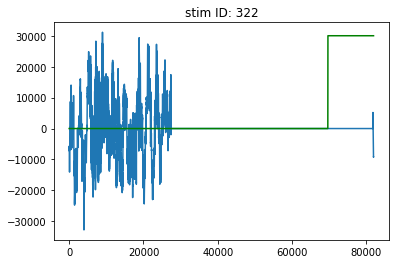

In [280]:
random_voc = np.random.choice(list(mVoc_wavforms.keys()))

plt.plot(mVoc_wavforms[random_voc])
plt.title(f"stim ID: {random_voc}")

zeros = np.zeros_like(mVoc_wavforms[random_voc])
silent_duration = 0.3
num_samples = int(silent_duration*sampling_rate)
zeros[-num_samples:] = 30000
plt.plot(zeros, color='green')

In [249]:
file_name = 'MonkVocs_15Blocks.wav'
file_path = os.path.join(neural_data_dir, file_name)





Frame rate (sample rate): 41000 Hz


(780,)

In [230]:
pulse_starts.shape

(780,)

In [245]:
durations.shape

(780,)

129622

In [224]:
durations

array([   410,    410,  88863,  63609,  79737, 170932,  72647, 158019,
        55724, 158790,  90730,  55985, 162394,  80875, 145954,  91468,
        64241,  67898,  86939, 149849,  93575,  67917,  78197, 117516,
        84397,  65948, 110565,  55768,  72145, 109397,  77364,  78465,
        54509,  52129, 112456, 100354,  64068,  63210,  82961,  83083,
        91748,  66985,  45913, 126380,  51115,  81547,  52716,  84250,
        95511,  95300, 116251,  84517,  66696,  68995, 121495, 104211,
        68233, 153398,  68892,  79797,  90336, 136203,  66395,  96584,
        77442,  58150, 114140,  79033,  52268,  54995,  90369, 114400,
        58014, 145976,  67531,  64340,  64944,  91904,  89069,  93891,
        91349,  56205,  75985,  72014, 192839,  61577, 136850,  88382,
        66598, 157549,  77881,  72710, 126003,  74515,  56210,  72450,
        78561,  95686,  83171,  68216, 110218, 115221,  99342, 118856,
        55735,  49058, 114034,  60996,  84876,  84450, 172712,  92252,
      

In [16]:
audio_data.shape

(68621258, 2)

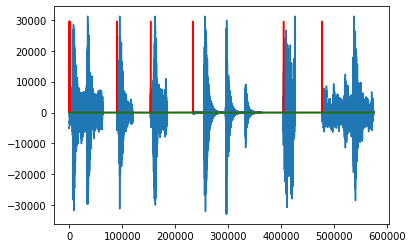

In [216]:
start_time = 0

num_seconds = 14
ch=0
pulse_number = 755
starting_samples = pulse_starts[pulse_number] #start_time*frame_rate
starting_samples = 0
num_samples = num_seconds*frame_rate
# num_samples = 16000

zeroes = np.zeros(num_samples)
silence_dur = 0.5
silence_samples = int(silence_dur*frame_rate)
for i in range(1,20):
	pulse = pulse_starts[pulse_number+i] - starting_samples
	if pulse > 0:
		if pulse <= zeroes.size:
			zeroes[pulse-silence_samples:pulse] = 30000
		else:
			break 


plt.plot(audio_data[:,ch][starting_samples:starting_samples+num_samples])
ch=1
plt.plot(audio_data[:,ch][starting_samples:starting_samples+num_samples], color='r')
plt.plot(zeroes, color='green')

In [165]:
starting_samples

66241004

In [176]:
ch=0
audio_data[:,ch][starting_samples:]

(2501255,)

In [169]:
audio_data.shape[0]

68621258

In [152]:
silence_samples

12300

In [17]:
total_time = audio_data.shape[0]/frame_rate

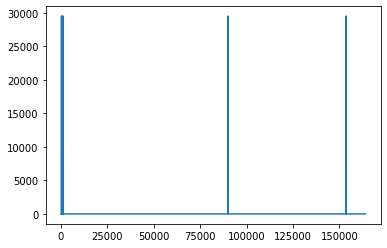

In [79]:
num_seconds = 4
num_samples = num_seconds*frame_rate
# num_samples = 16000
plt.plot(audio_data[:,1][:num_samples])

In [24]:
np.unique(audio_data[:,1])

array([    0, 29491], dtype=int16)

In [45]:
# Get the pulse information
pulse_starts, pulse_ends, pulse_lengths = extract_pulse_info(audio_data[:,1])

# # Print the results
# print(f"Pulse starts: {pulse_starts}")
# print(f"Pulse ends: {pulse_ends}")
# print(f"Pulse lengths: {pulse_lengths}")

In [63]:
# pulse_starts

In [75]:
stimOnset_times = pulse_starts/frame_rate
print(f"StimOnset times (derived from pulses):")
for i in range(10):
	print(f"Stim # {i}, Onset: {stimOnset_times[i]}")

StimOnset times (derived from pulses):
Stim # 0, Onset: 0.004975609756097561
Stim # 1, Onset: 0.01497560975609756
Stim # 2, Onset: 0.024975609756097562
Stim # 3, Onset: 2.1923658536585364
Stim # 4, Onset: 3.7438048780487807
Stim # 5, Onset: 5.688609756097561
Stim # 6, Onset: 9.857682926829268
Stim # 7, Onset: 11.629560975609756
Stim # 8, Onset: 15.483682926829268
Stim # 9, Onset: 16.84280487804878


In [49]:
np.unique(pulse_lengths)

array([205])

In [61]:
lengths_between_pulses = pulse_starts[1:] - pulse_ends[:-1]
inter_puses_duration = lengths_between_pulses/41000
print(f"Total duration between pulses: {np.sum(inter_puses_duration):.3f} sec")
print(f"Longest duration: {np.max(inter_puses_duration):.3f} sec")
print(f"Shortest duration: {np.min(inter_puses_duration[2:]):.3f} sec")
print(f"Shortest duration: {np.mean(inter_puses_duration[2:]):.3f} sec")

Total duration between pulses: 1666.618 sec
Longest duration: 4.789 sec
Shortest duration: 0.943 sec
Shortest duration: 2.139 sec


In [161]:
np.argmax(inter_puses_duration)

755

In [173]:
pulse_starts[754]

66120003

##### reading onset times from 'SqMoPhys_MVOCStimcodes.mat'

In [8]:
sqm_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mVocsStimCodes', 'mVocsStimOnTimes'])

In [9]:
sqm_data['mVocsStimCodes'].shape

(780,)

In [11]:
mat_file = 'SqMoPhys_MVOCStimcodes.mat'
sqm_data = io.loadmat(os.path.join(neural_data_dir, mat_file), struct_as_record = False, squeeze_me = True, )

mVocId_to_trialId = {}
mVocStimCodes = np.unique(sqm_data['mVocsStimCodes'])
mVoc_test_stimIds = []
mVoc_test_trIds = []

test_trial_repetitions = 15 
for stimCode in mVocStimCodes:
	mVocId_to_trialId[stimCode] = np.where(sqm_data['mVocsStimCodes']==stimCode)[0]
	if (mVocCode_to_trial_Code[stimCode].size == test_trial_repetitions):
		mVoc_test_stimIds.append(stimCode)
		mVoc_test_trIds.append(mVocId_to_trialId[stimCode])

mVoc_test_trIds = np.concatenate(mVoc_test_trIds)



In [12]:
mVoc_test_stimIds

[7, 9, 12, 15, 24, 29, 30, 33, 44, 45, 48]

In [13]:
mVocId_to_trialId[1]

array([  0,  32,  95, 107, 195, 227, 232, 277, 356, 403, 434, 490, 502,
       568, 575, 658, 683, 715, 770])

In [14]:
mVoc_test_trIds

array([  6,  75, 111, 182, 225, 296, 352, 364, 450, 496, 524, 610, 642,
       686, 754,   8, 101, 104, 159, 209, 274, 346, 377, 428, 491, 553,
       585, 630, 689, 741,  11,  91, 130, 163, 231, 290, 338, 375, 445,
       503, 526, 614, 633, 710, 746,  14,  60, 132, 190, 230, 260, 335,
       398, 461, 506, 532, 603, 660, 702, 765,  23, 103, 129, 175, 220,
       287, 351, 373, 437, 516, 556, 587, 673, 681, 735,  28,  58, 121,
       206, 235, 286, 326, 380, 455, 515, 522, 617, 666, 721, 764,  29,
        65, 138, 173, 250, 297, 355, 385, 422, 478, 549, 578, 655, 677,
       767,  33,  90, 131, 164, 242, 310, 315, 379, 447, 489, 559, 574,
       638, 716, 734,  47,  78, 143, 162, 215, 284, 320, 412, 452, 500,
       520, 577, 671, 705, 758,  48,  98, 110, 170, 222, 263, 337, 391,
       435, 498, 531, 596, 641, 700, 748,  51,  73, 117, 205, 254, 262,
       317, 366, 460, 488, 565, 602, 656, 694, 728])

In [25]:
for i in range(20,30):
	print(f"i={i}, {mVocCode_to_trial_Code[i].size}")

i=20, 19
i=21, 19
i=22, 19
i=23, 19
i=24, 19
i=25, 19
i=26, 19
i=27, 19
i=28, 19
i=29, 19


In [15]:
mVocCode_to_trial_Code

{1: array([  0,  32,  95, 107, 195, 227, 232, 277, 356, 403, 434, 490, 502,
        568, 575, 658, 683, 715, 770]),
 2: array([  0,  32,  95, 107, 195, 227, 232, 277, 356, 403, 434, 490, 502,
        568, 575, 658, 683, 715, 770]),
 3: array([  0,  32,  95, 107, 195, 227, 232, 277, 356, 403, 434, 490, 502,
        568, 575, 658, 683, 715, 770]),
 4: array([  0,  32,  95, 107, 195, 227, 232, 277, 356, 403, 434, 490, 502,
        568, 575, 658, 683, 715, 770]),
 5: array([  0,  32,  95, 107, 195, 227, 232, 277, 356, 403, 434, 490, 502,
        568, 575, 658, 683, 715, 770]),
 6: array([  0,  32,  95, 107, 195, 227, 232, 277, 356, 403, 434, 490, 502,
        568, 575, 658, 683, 715, 770]),
 7: array([  0,  32,  95, 107, 195, 227, 232, 277, 356, 403, 434, 490, 502,
        568, 575, 658, 683, 715, 770]),
 8: array([  0,  32,  95, 107, 195, 227, 232, 277, 356, 403, 434, 490, 502,
        568, 575, 658, 683, 715, 770]),
 9: array([  0,  32,  95, 107, 195, 227, 232, 277, 356, 403, 434, 490, 5

In [214]:
tr_presentations = {}
all_presentations = sqm_data['mVocsStimCodes']
total_presentations = 0
for tr in all_presentations:
	if tr in tr_presentations.keys():
		tr_presentations[tr] += 1
	else:
		tr_presentations[tr] = 1
	total_presentations += 1

voc_presentations = {}
for tr, present in tr_presentations.items():
	if present not in voc_presentations.keys():
		voc_presentations[present] = 1	
	else:
		voc_presentations[present] += 1

# print(f"Number of ")

In [215]:
sorted_voc_presentations = dict(list(sorted(voc_presentations.items(), key=lambda x: x[0])))

for pres, num_voc in sorted_voc_presentations.items():
	print(f"Number of Voc having {pres} presentaions = {num_voc}")

print(f"total presentations= {total_presentations}")

Number of Voc having 1 presentaions = 228
Number of Voc having 2 presentaions = 37
Number of Voc having 3 presentaions = 9
Number of Voc having 4 presentaions = 2
Number of Voc having 7 presentaions = 1
Number of Voc having 14 presentaions = 1
Number of Voc having 15 presentaions = 11
Number of Voc having 16 presentaions = 6
Number of Voc having 17 presentaions = 3
Number of Voc having 18 presentaions = 2
Number of Voc having 19 presentaions = 1
Number of Voc having 25 presentaions = 1
Number of Voc having 30 presentaions = 1
total presentations= 780


In [198]:
max_trial_with_repeat = 0
for tr, present in tr_presentations.items():
	if present > 1:
		max_trial_with_repeat = tr

In [199]:
max_trial_with_repeat

235

### mVoc spikes

In [2]:
from auditory_cortex.neural_data.dataset import NeuralData

session = '191210'
dataset = NeuralData(session)

NeuralData:  Creating object for session: 191210 ... Done.


In [59]:
mVocStimCodes = np.unique(dataset.spikes[0].mVocStimcode)
# mVocStimCodes
trial_ids = []
for mVoc in mVocStimCodes[1:]:
	trials = (np.where(dataset.trials[0].mVocStimcode == mVoc)[0]) + 1
	trial_ids.extend(list(trials))
trial_ids.sort()
mVoc_first_tr = np.min(trial_IDs)

trial_ids = trial_ids - mVoc_first_tr
all_trial_ids = np.arange(780)
missing_trial_ids = all_trial_ids[np.isin(all_trial_ids, trial_ids,invert=True)]

In [60]:
missing_trial_ids

array([178, 207, 358, 471, 513, 541, 544])

In [3]:
tr_id = 0
if tr_id in dataset.missing_trial_ids:
	raise ModuleNotFoundError("No trial data found...!")
tr = dataset.mVoc_first_tr + tr_id
# extract spike times using trial ID
s_times = dataset.retrieve_spike_times(trial=tr)


# win = win/1000
# counts = {}

# duration = round(self.duration(sent),3)  #round off to 3 decimals...
# bins = np.arange(delay, delay + duration, win)
# for i in range(self.num_channels):
# 	counts[i], _ = np.histogram(s_times[i], bins)

In [23]:
s_times.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [8]:
dataset.missing_trial_ids

array([178, 207, 358, 471, 513, 541, 544])

In [6]:
s_times[0]

array([-0.1337 ,  0.2331 ,  0.25235,  0.47445,  0.559  ,  0.58185,
        0.9481 ,  1.09565,  1.2469 ,  1.2569 ,  1.49165,  1.80865])

In [10]:
all_trials = dataset.metadata.mVocTrialIds
trials = all_trials[np.isin(all_trials, dataset.missing_trial_ids, invert=True)]

In [4]:
trials = None
bin_width = 100
delay=0

In [5]:
if trials is None:
	all_trials = dataset.metadata.mVocTrialIds
	trials = all_trials[np.isin(all_trials, dataset.missing_trial_ids, invert=True)]
raw_spikes = {}
for tr in trials:
	spikes = dataset.retrieve_mVoc_spike_counts(trial=tr, win=bin_width, delay=delay)
	raw_spikes[tr] = np.stack([spks for spks in spikes.values()], axis=1)

In [7]:
raw_spikes[0].shape

(18, 61)

In [7]:
dataset.metadata.get_mVoc_dur(tr_id)

1.8873902439024388

In [21]:
win = 100
delay = 50

# convert to seconds..
win = win/1000
delay = delay/1000

counts = {}

duration = round(dataset.metadata.get_mVoc_dur(tr_id),3)  #round off to 3 decimals...
bins = np.arange(delay, delay + duration, win)
for i in range(dataset.num_channels):
	counts[i], _ = np.histogram(s_times[i], bins)


In [22]:
counts[0]

array([0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1])

In [7]:
trial=0
win = 100
delay = 0

spikes = dataset.retrieve_mVoc_spike_counts(trial=trial, win=win, delay=delay)
print(f"Total spikes: {np.sum(spikes[0])}")
spikes[0]

Total spikes: 10


array([0, 0, 2, 0, 1, 2, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 0, 0])

In [ ]:
def spike_counts(self, sent=212, trial=0, win=50, delay=0):
	## Spike count using np.histogram function, this is in addition to
	#  my own binning implementation in Retrieve_spikes_count()
	# and they both give the same output
	s_times = self.retrieve_spike_times(sent=sent, trial=trial)
	win = win/1000
	counts = {}

	duration = round(self.duration(sent),3)  #round off to 3 decimals...
	bins = np.arange(delay, delay + duration, win)
	for i in range(self.num_channels):
		counts[i], _ = np.histogram(s_times[i], bins)
	return counts

In [52]:
np.max(trial_IDs)

1372

In [53]:
np.min(trial_IDs)

593

In [57]:
first_tr = 593
missing_IDs = []
for i in range(780):
	tr = first_tr+i
	if tr not in trial_IDs:
		missing_IDs.append(tr)



In [58]:
missing_IDs

[771, 800, 951, 1064, 1106, 1134, 1137]

In [56]:
if 178 in trial_IDs:
	print("Yes")

In [36]:
mVoc = 1
trials = (np.where(dataset.trials[0].mVocStimcode == mVoc)[0]) + 1
trials

array([ 593,  625,  688,  700,  788,  820,  825,  870,  949,  996, 1027,
       1083, 1095, 1161, 1168, 1251, 1276, 1308, 1363])

In [42]:
trial_IDs

[593,
 594,
 595,
 596,
 597,
 598,
 599,
 600,
 601,
 602,
 603,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 617,
 618,
 619,
 620,
 621,
 622,
 623,
 624,
 625,
 626,
 627,
 628,
 629,
 630,
 631,
 632,
 633,
 634,
 635,
 636,
 637,
 638,
 639,
 640,
 641,
 642,
 643,
 644,
 645,
 646,
 647,
 648,
 649,
 650,
 651,
 652,
 653,
 654,
 655,
 656,
 657,
 658,
 659,
 660,
 661,
 662,
 663,
 664,
 665,
 666,
 667,
 668,
 669,
 670,
 671,
 672,
 673,
 674,
 675,
 676,
 677,
 678,
 679,
 680,
 681,
 682,
 683,
 684,
 685,
 686,
 687,
 688,
 689,
 690,
 691,
 692,
 693,
 694,
 695,
 696,
 697,
 698,
 699,
 700,
 701,
 702,
 703,
 704,
 705,
 706,
 707,
 708,
 709,
 710,
 711,
 712,
 713,
 714,
 715,
 716,
 717,
 718,
 719,
 720,
 721,
 722,
 723,
 724,
 725,
 726,
 727,
 728,
 729,
 730,
 731,
 732,
 733,
 734,
 735,
 736,
 737,
 738,
 739,
 740,
 741,
 742,
 743,
 744,
 745,
 746,
 747,
 748,
 749,
 750,
 751,
 752,
 753,
 754,
 755,
 756,
 757,
 758,
 759

In [11]:
dataset.spikes[0]._fieldnames

['events',
 'spktimes',
 'stimlock',
 'amStimcode',
 'fmStimcode',
 'dmrStimcode',
 'mVocStimcode',
 'timitStimcode',
 'trial']

In [16]:
np.unique(dataset.trials[0].mVocStimcode)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [17]:
session = '200206'
dataset = NeuralData(session)

path = os.path.join(dataset.dir, dataset.sub)
spikes = {}
trials = {}
data = {}
dataset.names.sort()

name = dataset.names[0]

data = io.loadmat(os.path.join(path,name), squeeze_me = True, struct_as_record = False)

mVocStimCodes = np.unique(data['spike'].mVocStimcode)
number_of_trial_presentations = {}
# trials = np.arange(20)
for i in mVocStimCodes[1:]:
	num_presentations = np.where(data['trial'].mVocStimcode == i)[0].shape[0]
	if num_presentations in number_of_trial_presentations.keys():
		number_of_trial_presentations[num_presentations] +=1
	else:
		number_of_trial_presentations[num_presentations] =1



trials = list(number_of_trial_presentations.keys())
trials = np.sort(trials)
print(f"Session-{session}, detail of trials presentations:")
total = 0
total_trials = 0
for tr in trials:
	print(f"Number of mVoc having {tr} presentations = {number_of_trial_presentations[tr]}")
	total += number_of_trial_presentations[tr]
	total_trials += tr*number_of_trial_presentations[tr]
print(f"Total unique mVocs = {total}")
print(f"Total trial presentations: {total_trials}")

NeuralData:  Creating object for session: 200206 ... Done.
Session-200206, detail of trials presentations:
Number of mVoc having 1 presentations = 228
Number of mVoc having 2 presentations = 37
Number of mVoc having 3 presentations = 9
Number of mVoc having 4 presentations = 2
Number of mVoc having 7 presentations = 1
Number of mVoc having 14 presentations = 1
Number of mVoc having 15 presentations = 11
Number of mVoc having 16 presentations = 6
Number of mVoc having 17 presentations = 3
Number of mVoc having 18 presentations = 2
Number of mVoc having 19 presentations = 1
Number of mVoc having 25 presentations = 1
Number of mVoc having 30 presentations = 1
Total unique mVocs = 303
Total trial presentations: 780


In [35]:
dataset.sentdet[0]._fieldnames

['name',
 'sound',
 'soundf',
 'dataf',
 'aud',
 'duration',
 'befaft',
 'sentId',
 'soundOns',
 'onsOff',
 'syltype',
 'phnmatonset',
 'phnmat',
 'sentence_onset',
 'formants',
 'F13P',
 'F23P',
 'F1Trans',
 'F2Trans',
 'phnfeat',
 'phnfeatonset',
 'sylOns',
 'syllableNumber',
 'pause',
 'stress',
 'vowelTimes',
 'vowel',
 'vowelStress',
 'frmMedOns',
 'frmMedVal',
 'vowelId',
 'loudnessallNames',
 'loudness',
 'loudnessExtVal',
 'loudnessExtLoc',
 'loudnessRelExtLoc',
 'loudnessall',
 'loudnessSentOns',
 'loudnessCycleDur',
 'loudnessSentIdlong',
 'loudnesscyclePeakPhn',
 'loudnessCycleId']

In [36]:
dataset.sentdet[0].sound

array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
dataset.sentdet[0].aud.shape

(80, 280)

In [38]:
session = '191210'
dataset = NeuralData(session)

path = os.path.join(dataset.dir, dataset.sub)
spikes = {}
trials = {}
data = {}
dataset.names.sort()

name = dataset.names[0]

data = io.loadmat(os.path.join(path,name), squeeze_me = True, struct_as_record = False)

mVocStimCodes = np.unique(data['spike'].mVocStimcode)
number_of_trial_presentations = {}
# trials = np.arange(20)
for i in mVocStimCodes[1:]:
	num_presentations = np.where(data['trial'].mVocStimcode == i)[0].shape[0]
	if num_presentations in number_of_trial_presentations.keys():
		number_of_trial_presentations[num_presentations] +=1
	else:
		number_of_trial_presentations[num_presentations] =1



trials = list(number_of_trial_presentations.keys())
trials = np.sort(trials)
print(f"Session-{session}, detail of trials presentations:")
total = 0
total_trials = 0
for tr in trials:
	print(f"Number of mVoc having {tr} presentations = {number_of_trial_presentations[tr]}")
	total += number_of_trial_presentations[tr]
	total_trials += tr*number_of_trial_presentations[tr]
print(f"Total unique mVocs = {total}")
print(f"Total trial presentations: {total_trials}")

NeuralData:  Creating object for session: 191210 ... Done.
Session-191210, detail of trials presentations:
Number of mVoc having 1 presentations = 221
Number of mVoc having 2 presentations = 37
Number of mVoc having 3 presentations = 9
Number of mVoc having 4 presentations = 2
Number of mVoc having 7 presentations = 1
Number of mVoc having 14 presentations = 1
Number of mVoc having 15 presentations = 11
Number of mVoc having 16 presentations = 6
Number of mVoc having 17 presentations = 3
Number of mVoc having 18 presentations = 2
Number of mVoc having 19 presentations = 1
Number of mVoc having 25 presentations = 1
Number of mVoc having 30 presentations = 1
Total unique mVocs = 296
Total trial presentations: 773


In [39]:
session = '180731'
dataset = NeuralData(session)

path = os.path.join(dataset.dir, dataset.sub)
spikes = {}
trials = {}
data = {}
dataset.names.sort()

name = dataset.names[0]

data = io.loadmat(os.path.join(path,name), squeeze_me = True, struct_as_record = False)

mVocStimCodes = np.unique(data['spike'].mVocStimcode)
number_of_trial_presentations = {}
# trials = np.arange(20)
for i in mVocStimCodes[1:]:
	num_presentations = np.where(data['trial'].mVocStimcode == i)[0].shape[0]
	if num_presentations in number_of_trial_presentations.keys():
		number_of_trial_presentations[num_presentations] +=1
	else:
		number_of_trial_presentations[num_presentations] =1



trials = list(number_of_trial_presentations.keys())
trials = np.sort(trials)
print(f"Session-{session}, detail of trials presentations:")
total = 0
total_trials = 0
for tr in trials:
	print(f"Number of mVoc having {tr} presentations = {number_of_trial_presentations[tr]}")
	total += number_of_trial_presentations[tr]
	total_trials += tr*number_of_trial_presentations[tr]
print(f"Total unique mVocs = {total}")
print(f"Total trial presentations: {total_trials}")

NeuralData:  Creating object for session: 180731 ... Done.
Session-180731, detail of trials presentations:
Number of mVoc having 1 presentations = 226
Number of mVoc having 2 presentations = 37
Number of mVoc having 3 presentations = 9
Number of mVoc having 4 presentations = 2
Number of mVoc having 7 presentations = 1
Number of mVoc having 14 presentations = 1
Number of mVoc having 15 presentations = 11
Number of mVoc having 16 presentations = 6
Number of mVoc having 17 presentations = 3
Number of mVoc having 18 presentations = 2
Number of mVoc having 19 presentations = 1
Number of mVoc having 25 presentations = 1
Number of mVoc having 30 presentations = 1
Total unique mVocs = 301
Total trial presentations: 778


In [62]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'AMTrain', 'FMTrain', 'TIMITSegTrain', 'TIMITTrain', 'mVocTrain', 'spike', 'trial'])

In [86]:
data['spike']._fieldnames

['events',
 'spktimes',
 'stimlock',
 'amStimcode',
 'fmStimcode',
 'dmrStimcode',
 'mVocStimcode',
 'timitStimcode',
 'trial']

In [17]:
mVocStimCodes = np.unique(data['spike'].mVocStimcode)

In [18]:
mVocStimCodes

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [31]:
number_of_trial_presentations = {}
# trials = np.arange(20)
for i in mVocStimCodes[1:]:
	num_presentations = np.where(data['trial'].mVocStimcode == i)[0].shape[0]
	if num_presentations in number_of_trial_presentations.keys():
		number_of_trial_presentations[num_presentations] +=1
	else:
		number_of_trial_presentations[num_presentations] =1



trials = list(number_of_trial_presentations.keys())
trials = np.sort(trials)
print(f"Session-{session}, detail of trials presentations:")
total = 0
for tr in trials:
	print(f"Number of mVoc having {tr} presentations = {number_of_trial_presentations[tr]}")
	total += number_of_trial_presentations[tr]
print(f"Total unique mVocs = {total}")

Session-200206, detail of trials presentations:
Number of mVoc having 1 presentations = 228
Number of mVoc having 2 presentations = 37
Number of mVoc having 3 presentations = 9
Number of mVoc having 4 presentations = 2
Number of mVoc having 7 presentations = 1
Number of mVoc having 14 presentations = 1
Number of mVoc having 15 presentations = 11
Number of mVoc having 16 presentations = 6
Number of mVoc having 17 presentations = 3
Number of mVoc having 18 presentations = 2
Number of mVoc having 19 presentations = 1
Number of mVoc having 25 presentations = 1
Number of mVoc having 30 presentations = 1
Total unique mVocs = 303


In [28]:
trials

array([ 1,  2,  3,  4,  7, 14, 15, 16, 17, 18, 19, 25, 30])

In [26]:
number_of_trial_presentations

{19: 1,
 1: 228,
 16: 6,
 2: 37,
 17: 3,
 15: 11,
 3: 9,
 18: 2,
 30: 1,
 25: 1,
 14: 1,
 4: 2,
 7: 1}

In [105]:
np.where(data['trial'].mVocStimcode == 9)[0].shape

(15,)

In [94]:
np.where(mVocStimCodes==1)

(array([ 60197,  60198,  60199, ..., 105671, 105672, 105673]),)

In [80]:
aud = data['TIMITTrain'][3][0]

In [82]:
from IPython.display import Audio
Audio(data=aud, rate=16000)

In [70]:
data['spike']

In [ ]:
for i, name in enumerate(self.names):
	if verbose:
	print(name)
	if 'MUspk' in name:
	# print(name)
	data[i] = io.loadmat(os.path.join(path,name), squeeze_me = True, struct_as_record = False)
	spikes[i] = data[i]['spike']
	trials[i] = data[i]['trial']

return spikes, trials